In [11]:
import phoebe
import numpy as np
from phoebe import u
import matplotlib.pyplot as plt
%matplotlib inline

# TODO: how to save?
import pickle

with open('test_single_sun_10000_triangles_spot.pickle', 'rb') as f:
    b = pickle.load(f)
    
from spectrum import *
import jax.numpy as jnp
import jax

from phoebe_utils import PhoebeConfig

In [12]:
from jax.config import config
config.update("jax_enable_x64", True)

In [22]:
config = PhoebeConfig(b, 'mesh01')
time = config.times[0]
coords = config.get_mesh_coordinates(time)
VW = config.get_radial_velocities(time)

mus = config.get_mus(time)
print(np.min(mus), np.max(mus))
pos_mus = np.argwhere(mus>0)

projected_areas = config.get_projected_areas(time)

mus = jnp.array(mus[pos_mus])
areas = jnp.array(projected_areas[pos_mus])
vrads = jnp.array(VW[pos_mus])

-0.9999494286626613 0.9999302033165274


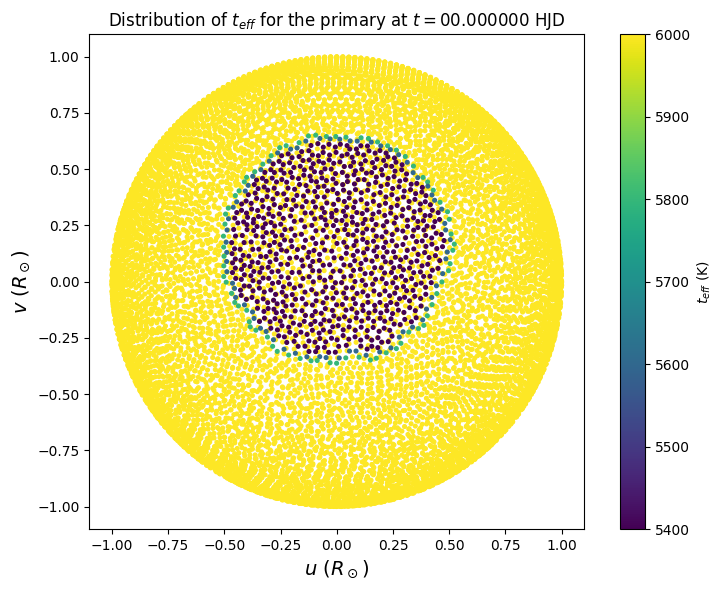

In [15]:
coords = config.get_mesh_coordinates(time)
teffs = config.get_teffs(time)

#example plot of the radial velocities of centers of triangular surface elements for the primary component
#just to show/check that everything works fine and smoothly :)
plt.figure(figsize=(8,6))
plt.gca().set_aspect('equal')
plt.scatter(coords[:, 0], coords[:, 1], marker='o',c=teffs,s=7)
plt.xlabel(r'$u$ ($R_\odot$)',fontsize=14)
plt.ylabel(r'$v$ ($R_\odot$)',fontsize=14)
plt.title(r'Distribution of $t_{eff}$ for the primary at $t=$'+str(time)+' HJD',fontsize=12)
plt.colorbar(label=r'$t_{eff}$ (K)')
plt.tight_layout()
plt.show()

In [21]:
np.max(mus)

Array(0.9999302, dtype=float64)

In [10]:
mus.shape, areas.shape, vrads.shape

((5706, 1), (5706, 1), (5706, 1))

In [12]:
# Gaussowskie prędkości na powierzchni gwiazdy- symulacja turbulencji

In [13]:
LOG_WAVELENGTHS = jnp.linspace(3.65, 3.85, 10000)
atmosphere_mul = jnp.multiply(areas.reshape((-1, 1, 1)),
    atmosphere_flux(LOG_WAVELENGTHS, mus))

In [14]:
atmosphere_mul = jnp.multiply(
    areas.reshape((-1, 1, 1)),
    atmosphere_flux(LOG_WAVELENGTHS,
                    mus))

# (observed) radial velocity correction for both continuum and spectrum correction
# Shape: (n_vertices, 2, n_wavelengths)
vrad_atmosphere = jax.vmap(
    lambda a: v_interp(
        LOG_WAVELENGTHS,
        v_apply_vrad(
            LOG_WAVELENGTHS,
            vrads),
        a), in_axes=(1,))(atmosphere_mul)

atmo = jnp.sum(vrad_atmosphere, axis=1)/jnp.sum(areas, axis=0)

atmo.shape

(2, 10000)

In [15]:
LOG_WAVELENGTHS = jnp.linspace(3.65, 3.85, 50000)
chunk_size = 512

flash_atmosphere_full_vrad = spectrum_flash_sum(LOG_WAVELENGTHS, areas, mus, vrads, chunk_size)
flash_atmosphere_half_vrad = spectrum_flash_sum(LOG_WAVELENGTHS, areas, mus, 0.5*vrads, chunk_size)
flash_atmosphere_twice_vrad = spectrum_flash_sum(LOG_WAVELENGTHS, areas, mus, 2.*vrads, chunk_size)
flash_atmosphere_no_rot = spectrum_flash_sum(LOG_WAVELENGTHS, areas, mus, jnp.zeros_like(vrads), chunk_size)

In [16]:
flash_atmosphere_thrice_vrad = spectrum_flash_sum(LOG_WAVELENGTHS, areas, mus, 3.*vrads, chunk_size)

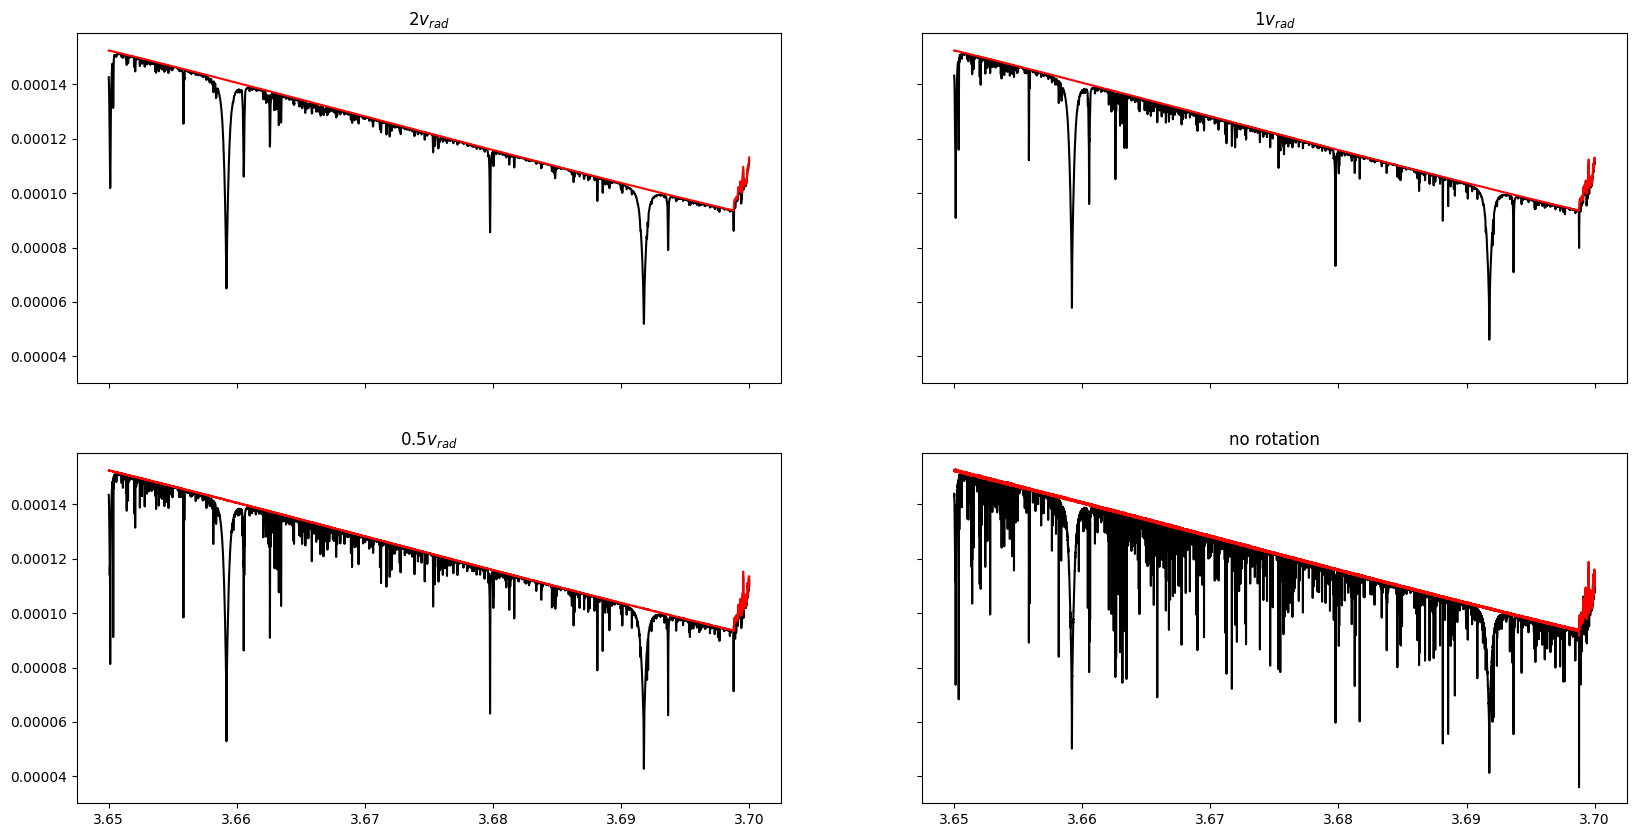

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10), sharex=True, sharey=True)

logwaves = jnp.linspace(3.65, 3.7, 50000)

ax[0, 0].plot(logwaves, flash_atmosphere_twice_vrad[0], color='black');
ax[0, 0].plot(logwaves, flash_atmosphere_twice_vrad[1], color='red');
ax[0, 0].set_title(r'$2v_{rad}$');
ax[0, 1].plot(logwaves, flash_atmosphere_full_vrad[0], color='black');
ax[0, 1].plot(logwaves, flash_atmosphere_full_vrad[1], color='red');
ax[0, 1].set_title(r'$1v_{rad}$');
ax[1, 0].plot(logwaves, flash_atmosphere_half_vrad[0], color='black');
ax[1, 0].plot(logwaves, flash_atmosphere_half_vrad[1], color='red');
ax[1, 0].set_title(r'$0.5v_{rad}$');
ax[1, 1].plot(logwaves, flash_atmosphere_no_rot[0], color='black');
ax[1, 1].plot(logwaves, flash_atmosphere_no_rot[1], color='red');
ax[1, 1].set_title(r'no rotation');
#plt.plot(flash_atmosphere[:, 1]);

In [ ]:
jnp.argmin(jnp.abs(jnp.linspace(3.65, 3.7, 50000)-3.691775)), jnp.argmin(jnp.abs(jnp.linspace(3.65, 3.7, 50000)-3.69155))

In [ ]:
base = plt.cm.get_cmap('turbo')
color_list = base(np.linspace(0, 1, 6))

In [ ]:
10**3.69155

In [ ]:
plt.plot(logwaves, flash_atmosphere_thrice_vrad[0], color=color_list[0], label='3.0$v_{rad}$', linestyle='dotted');
plt.plot(logwaves, flash_atmosphere_twice_vrad[0], color=color_list[1], label='2.0$v_{rad}$');
plt.plot(logwaves, flash_atmosphere_full_vrad[0], color=color_list[2], label='1.0$v_{rad}$', linestyle='--');
plt.plot(logwaves, flash_atmosphere_half_vrad[0], color='orange', label='0.5$v_{rad}$');
plt.plot(logwaves, flash_atmosphere_no_rot[0], color=color_list[4], label='no rotation');
plt.gca().set_xlim(3.6912, 3.6923);
plt.gca().set_ylim(3.5e-5, 11e-5)
plt.gca().vlines(3.691775, 3.5e-5, 11e-5, color='black', linewidth=1.)
plt.text(3.691785, 1e-4, '$4917.85$ $\AA$');
plt.gca().vlines(3.69155, 3.5e-5, 11e-5, color='red', linewidth=1.)
plt.text(3.691557, 1e-4, '$4915.30$ $\AA$', color='red');
plt.gca().set_ylabel('flux')
plt.gca().set_xlabel('log wavelength [log $\AA$]');
plt.legend();

In [ ]:
grad = jax.jit(jax.grad(lambda v: spectrum_flash_sum(LOG_WAVELENGTHS, areas, mus, vrads*v, 512)[0, 41774]))
grad2 = jax.jit(jax.grad(lambda v: spectrum_flash_sum(LOG_WAVELENGTHS, areas, mus, vrads*v, 512)[0, 41549]))

In [ ]:
g = jax.jit(jax.vmap(grad))
g2 = jax.jit(jax.vmap(grad2))

In [ ]:
grads = jax.lax.scan(lambda _, x: (None, g(x)), None, jnp.linspace(0., 3., 50).reshape((10, 5)))[1]

In [ ]:
grads2 = jax.lax.scan(lambda _, x: (None, g2(x)), None, jnp.linspace(0., 3., 50).reshape((10, 5)))[1]

In [ ]:
plt.plot(jnp.linspace(0., 3., 50), grads.flatten(), color='black', label='$4917.84$ $\AA$')
plt.plot(jnp.linspace(0., 3., 50), grads2.flatten(), color='red', label='$4915.30$ $\AA$')
plt.hlines(0., -.2, 3.2, color='black')
plt.gca().set_xlim(-.1, 3.1);
plt.gca().set_xlabel('$v_{rad}$ multiplier')
plt.gca().set_ylabel('d(flux)/d(multiplier)')
plt.legend();